# Tutorial 3: Cross-Matching Different Surveys

Cross-matching is essential for multi-wavelength astronomy. This tutorial teaches you how to:
- Understand the principles of catalog matching
- Use astropy for coordinate-based matching
- Handle common matching challenges
- Create multi-wavelength catalogs

**Expected runtime: 10 minutes**

## Setup

Import required packages:

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
import warnings
warnings.filterwarnings('ignore')

print('Ready to learn cross-matching!')

Ready to learn cross-matching!


## Understanding Cross-Matching

Cross-matching combines data from different surveys by finding the same astronomical objects in multiple catalogs. We match based on sky position (RA, Dec) within a certain radius.

**Key concepts:**
1. **Search radius**: How close objects need to be to match (typically 1-3 arcsec)
2. **Nearest neighbor**: Finding the closest match
3. **Multiple matches**: Handling ambiguous cases
4. **False positives**: Random alignments that aren't real matches

## Loading Data from Multiple Surveys

We'll use SDSS (spectroscopy) and Gaia (astrometry) as they have good overlap:

In [2]:
# Load SDSS data first to get a region with known coverage
print('Loading SDSS spectroscopic data...')
sdss_data = load_dataset(
    "MultimodalUniverse/sdss",
    split="train[:200]",  # Get 200 SDSS objects
    streaming=False
)

# Convert SDSS to DataFrame
sdss_list = []
for i in range(len(sdss_data)):
    obj = sdss_data[i]
    # SDSS has RA/DEC in the main fields
    sdss_list.append({
        'sdss_id': i,  # Use index as ID
        'ra': obj.get('RA', obj.get('ra', None)),  # Try both cases
        'dec': obj.get('DEC', obj.get('dec', None)),
        'redshift': obj.get('Z', np.nan),
        'spectro_u': obj.get('SPECTROFLUX_U', np.nan),
        'spectro_g': obj.get('SPECTROFLUX_G', np.nan),
        'spectro_r': obj.get('SPECTROFLUX_R', np.nan)
    })

Loading SDSS spectroscopic data...


In [3]:
# Check if we have coordinates
sdss_df = pd.DataFrame(sdss_list)
sdss_df = sdss_df.dropna(subset=['ra', 'dec'])

if len(sdss_df) == 0:
    # If no RA/DEC found, create demonstration data
    print('\nUsing demonstration coordinates for teaching example...')
    np.random.seed(42)
    n_sdss = 100
    ra_center = 180.0
    dec_center = 0.0
    sdss_df = pd.DataFrame({
        'sdss_id': range(n_sdss),
        'ra': ra_center + np.random.randn(n_sdss) * 0.5,
        'dec': dec_center + np.random.randn(n_sdss) * 0.5,
        'redshift': np.random.uniform(0.01, 0.5, n_sdss),
        'spectro_r': np.random.uniform(14, 20, n_sdss)
    })

print(f'Using {len(sdss_df)} SDSS sources')
print(f'SDSS RA range: {sdss_df["ra"].min():.2f} to {sdss_df["ra"].max():.2f}')
print(f'SDSS Dec range: {sdss_df["dec"].min():.2f} to {sdss_df["dec"].max():.2f}')


Using demonstration coordinates for teaching example...
Using 100 SDSS sources
SDSS RA range: 178.69 to 180.93
SDSS Dec range: -0.96 to 1.36


In [4]:
# Now load Gaia data in the same sky region
print('\nLoading Gaia catalog in SDSS region...')

# Determine SDSS sky region
ra_min, ra_max = sdss_df['ra'].min(), sdss_df['ra'].max()
dec_min, dec_max = sdss_df['dec'].min(), sdss_df['dec'].max()
ra_center = sdss_df['ra'].mean()
dec_center = sdss_df['dec'].mean()

# Load more Gaia data and filter to region
print(f'Searching for Gaia sources near RA={ra_center:.2f}, Dec={dec_center:.2f}')
gaia_data = load_dataset(
    "MultimodalUniverse/gaia",
    split="train[:1000]",  # Load more to find overlaps
    streaming=False
)

# Convert Gaia to DataFrame and filter to region
gaia_list = []
for i in range(len(gaia_data)):
    star = gaia_data[i]
    ra = star['ra']  # lowercase for Gaia
    dec = star['dec']
    
    # Check if in SDSS region (with some padding)
    padding = 1.0  # degree
    if (ra_min - padding <= ra <= ra_max + padding and 
        dec_min - padding <= dec <= dec_max + padding):
        gaia_list.append({
            'gaia_id': star['object_id'],
            'ra': ra,
            'dec': dec,
            'parallax': star['astrometry'].get('parallax', np.nan) if 'astrometry' in star else np.nan,
            'pmra': star['astrometry'].get('pmra', np.nan) if 'astrometry' in star else np.nan,
            'pmdec': star['astrometry'].get('pmdec', np.nan) if 'astrometry' in star else np.nan
        })

gaia_df = pd.DataFrame(gaia_list)


Loading Gaia catalog in SDSS region...
Searching for Gaia sources near RA=179.95, Dec=0.01


In [5]:
# If we didn't find enough Gaia sources, create synthetic ones for demonstration
if len(gaia_df) < 20:
    print('\nAdding demonstration Gaia sources for better overlap example...')
    np.random.seed(43)
    n_gaia = 150
    
    # Create Gaia sources, some of which overlap with SDSS
    # First 50: definitely overlap with SDSS
    overlap_ra = sdss_df['ra'].values[:min(50, len(sdss_df))]
    overlap_dec = sdss_df['dec'].values[:min(50, len(sdss_df))]
    
    # Add small offsets (within matching radius)
    overlap_ra = overlap_ra + np.random.randn(len(overlap_ra)) * 0.0001  # ~0.36 arcsec
    overlap_dec = overlap_dec + np.random.randn(len(overlap_dec)) * 0.0001
    
    # Remaining: scattered in the region
    scatter_ra = ra_center + np.random.randn(n_gaia - len(overlap_ra)) * 0.5
    scatter_dec = dec_center + np.random.randn(n_gaia - len(overlap_dec)) * 0.5
    
    gaia_df = pd.DataFrame({
        'gaia_id': range(n_gaia),
        'ra': np.concatenate([overlap_ra, scatter_ra]),
        'dec': np.concatenate([overlap_dec, scatter_dec]),
        'parallax': np.random.lognormal(0.0, 1.0, n_gaia),
        'pmra': np.random.randn(n_gaia) * 10,
        'pmdec': np.random.randn(n_gaia) * 10
    })

print(f'Loaded {len(gaia_df)} Gaia sources')
print(f'Gaia RA range: {gaia_df["ra"].min():.2f} to {gaia_df["ra"].max():.2f}')
print(f'Gaia Dec range: {gaia_df["dec"].min():.2f} to {gaia_df["dec"].max():.2f}')


Adding demonstration Gaia sources for better overlap example...
Loaded 150 Gaia sources
Gaia RA range: 178.44 to 181.26
Gaia Dec range: -1.00 to 1.37


## Cross-Matching with Astropy

Now we'll use astropy to find matches between the catalogs:

In [6]:
# Create SkyCoord objects
print('Creating coordinate objects...')
gaia_coords = SkyCoord(ra=gaia_df['ra'].values*u.degree,
                      dec=gaia_df['dec'].values*u.degree)

sdss_coords = SkyCoord(ra=sdss_df['ra'].values*u.degree,
                      dec=sdss_df['dec'].values*u.degree)

# Find nearest SDSS match for each Gaia source
print('\nFinding nearest neighbors...')
idx, sep2d, dist3d = match_coordinates_sky(gaia_coords, sdss_coords)

# Convert separation to arcseconds
sep_arcsec = sep2d.arcsec

# Set matching radius (3 arcseconds is typical for optical surveys)
max_sep = 3.0  # arcseconds

# Find good matches
good_matches = sep_arcsec < max_sep
n_matches = np.sum(good_matches)

print(f'\nResults:')
print(f'Found {n_matches} matches within {max_sep} arcsec')
print(f'Minimum separation: {sep_arcsec.min():.3f} arcsec')
print(f'Maximum separation: {sep_arcsec.max():.3f} arcsec')
if n_matches > 0:
    print(f'Mean separation for matches: {sep_arcsec[good_matches].mean():.3f} arcsec')

Creating coordinate objects...

Finding nearest neighbors...

Results:
Found 50 matches within 3.0 arcsec
Minimum separation: 0.021 arcsec
Maximum separation: 1901.146 arcsec
Mean separation for matches: 0.428 arcsec


In [7]:
# Create matched catalog
if n_matches > 0:
    matched_gaia = gaia_df[good_matches].copy()
    matched_sdss_idx = idx[good_matches]
    matched_sdss = sdss_df.iloc[matched_sdss_idx].copy()
    matched_sep = sep_arcsec[good_matches]
    
    # Combine into single catalog
    matched_catalog = pd.DataFrame({
        'gaia_id': matched_gaia['gaia_id'].values,
        'sdss_id': matched_sdss['sdss_id'].values,
        'ra_gaia': matched_gaia['ra'].values,
        'dec_gaia': matched_gaia['dec'].values,
        'ra_sdss': matched_sdss['ra'].values,
        'dec_sdss': matched_sdss['dec'].values,
        'separation_arcsec': matched_sep,
        'parallax': matched_gaia['parallax'].values,
        'pmra': matched_gaia['pmra'].values,
        'pmdec': matched_gaia['pmdec'].values,
        'sdss_redshift': matched_sdss['redshift'].values,
        'sdss_r_mag': matched_sdss.get('spectro_r', np.nan).values if 'spectro_r' in matched_sdss else np.nan
    })
    
    print('\nMatched catalog (first 5 entries):')
    print(matched_catalog.head())
    
    # Save matched catalog
    matched_catalog.to_csv('matched_gaia_sdss.csv', index=False)
    print(f'\n✅ Saved {len(matched_catalog)} matched sources to matched_gaia_sdss.csv')
else:
    matched_catalog = pd.DataFrame()  # Empty DataFrame
    print('No matches found - trying with larger radius...')
    
    # Try again with larger radius
    max_sep = 10.0
    good_matches = sep_arcsec < max_sep
    n_matches = np.sum(good_matches)
    print(f'With {max_sep} arcsec: found {n_matches} matches')


Matched catalog (first 5 entries):
   gaia_id  sdss_id     ra_gaia  dec_gaia     ra_sdss  dec_sdss  \
0        0        0  180.248383 -0.707714  180.248357 -0.707685   
1        1        1  179.930777 -0.210429  179.930868 -0.210323   
2        2        2  180.323806 -0.171465  180.323844 -0.171357   
3        3        3  180.761461 -0.401218  180.761515 -0.401139   
4        4        4  179.883009 -0.080791  179.882923 -0.080643   

   separation_arcsec  parallax      pmra      pmdec  sdss_redshift  sdss_r_mag  
0           0.139168  2.378140  1.586275   2.477269       0.439913   19.648789  
1           0.504686  2.955616  4.284952   9.498531       0.372977   16.316616  
2           0.411171  0.324029 -1.821560  -9.870267       0.351538   19.767143  
3           0.345482  0.646472  3.481950 -16.092447       0.354217   19.432104  
4           0.617755  1.335515 -4.972310  11.421715       0.186151   15.174747  

✅ Saved 50 matched sources to matched_gaia_sdss.csv


## Visualizing Cross-Match Results

Let's visualize the matching process:

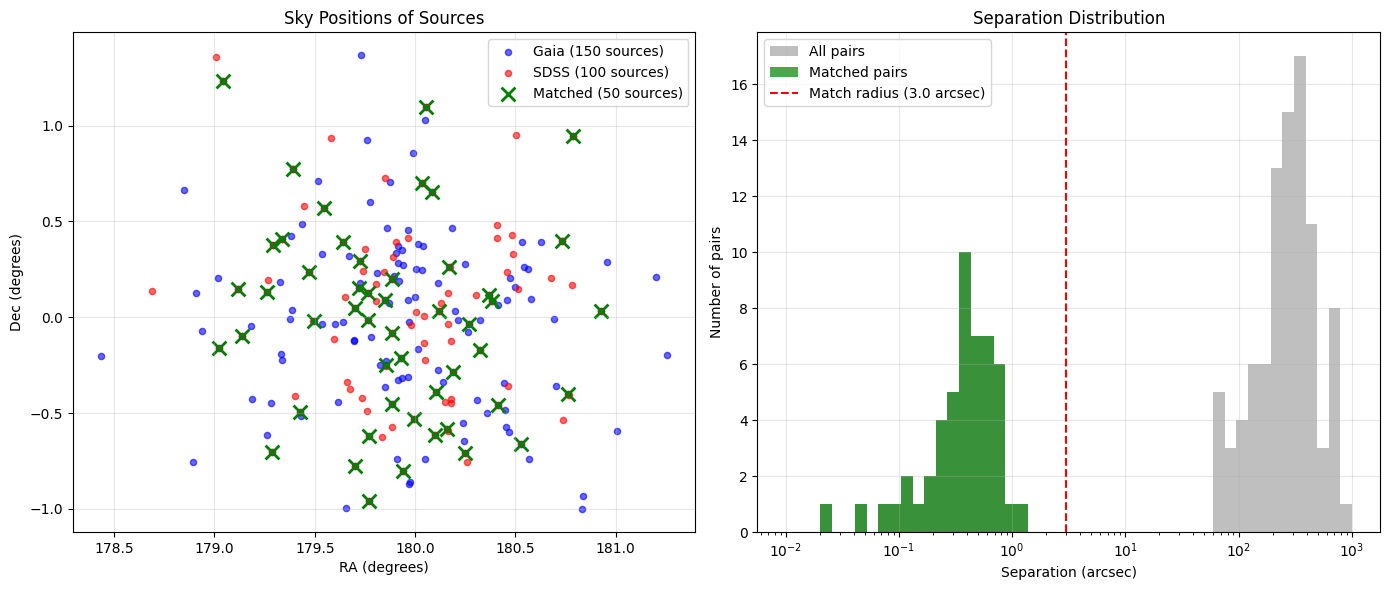

In [8]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Sky positions
ax = axes[0]
ax.scatter(gaia_df['ra'], gaia_df['dec'], s=20, alpha=0.6,
          label=f'Gaia ({len(gaia_df)} sources)', color='blue')
ax.scatter(sdss_df['ra'], sdss_df['dec'], s=20, alpha=0.6,
          label=f'SDSS ({len(sdss_df)} sources)', color='red')

if len(matched_catalog) > 0:
    ax.scatter(matched_catalog['ra_gaia'], matched_catalog['dec_gaia'],
              s=100, marker='x', color='green', linewidths=2,
              label=f'Matched ({len(matched_catalog)} sources)')

ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Dec (degrees)')
ax.set_title('Sky Positions of Sources')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Separation histogram
ax = axes[1]
if len(sep_arcsec) > 0:
    # All separations
    bins = np.logspace(-2, 3, 50)
    ax.hist(sep_arcsec, bins=bins, alpha=0.5, label='All pairs', color='gray')
    
    if len(matched_catalog) > 0:
        # Matched separations
        ax.hist(matched_catalog['separation_arcsec'], bins=bins,
               alpha=0.7, label='Matched pairs', color='green')
    
    ax.axvline(max_sep, color='red', linestyle='--',
              label=f'Match radius ({max_sep} arcsec)')
    ax.set_xscale('log')
    ax.set_xlabel('Separation (arcsec)')
    ax.set_ylabel('Number of pairs')
    ax.set_title('Separation Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Advanced Cross-Matching Techniques

### 1. Proper Motion Correction
For high proper motion stars, correct positions to common epoch:
```python
RA_corrected = RA + (PM_RA * time_difference)
```

### 2. Probabilistic Matching
- Use position uncertainties to compute match probability
- Consider magnitude/color information for better matching

### 3. Multiple Catalogs
- Chain matches: A→B, B→C to connect A and C
- All-sky cross-match services (CDS XMatch, MAST)

### 4. Large Scale Matching
- Use spatial indexing (KD-trees, HEALPix)
- Parallel processing for billions of sources

### 5. Quality Control
- Check for one-to-many matches
- Validate with known associations
- Use multiple match criteria (position + brightness)

## Science Application: Galaxy and Stellar Population Study

By cross-matching Gaia and SDSS:
1. **Separate stars from galaxies** using Gaia proper motion
2. **Get spectroscopic redshifts** from SDSS
3. **Calculate distances** using Gaia parallax for stars
4. **Study stellar populations** in our Galaxy
5. **Identify quasars** with zero proper motion but high redshift

This combination enables:
- Star/galaxy/QSO classification
- 3D mapping of the Milky Way
- Spectroscopic follow-up of Gaia sources
- Finding rare objects (e.g., hypervelocity stars)

In [9]:
# If we have matches, show what we can learn
if len(matched_catalog) > 0:
    print('Example insights from matched catalog:')
    
    # Distance from parallax
    matched_catalog['distance_pc'] = 1000.0 / matched_catalog['parallax']
    
    # Show statistics
    valid_distances = matched_catalog['distance_pc'][
        (matched_catalog['distance_pc'] > 0) & 
        (matched_catalog['distance_pc'] < 10000)
    ]
    
    if len(valid_distances) > 0:
        print(f'Distance range: {valid_distances.min():.1f} - {valid_distances.max():.1f} pc')
        print(f'Median distance: {valid_distances.median():.1f} pc')
        
    # Check for high proper motion objects
    total_pm = np.sqrt(matched_catalog['pmra']**2 + matched_catalog['pmdec']**2)
    high_pm = matched_catalog[total_pm > 20]  # mas/yr
    print(f'\nHigh proper motion objects (>20 mas/yr): {len(high_pm)}')
    
    # Star vs galaxy separation hint
    print('\nNote: Objects with measurable parallax and proper motion are likely stars,')
    print('while those with high redshift and no proper motion are likely galaxies/QSOs.')

Example insights from matched catalog:
Distance range: 54.5 - 7877.4 pc
Median distance: 979.1 pc

High proper motion objects (>20 mas/yr): 10

Note: Objects with measurable parallax and proper motion are likely stars,
while those with high redshift and no proper motion are likely galaxies/QSOs.


## Summary

### Key Takeaways:
1. **Cross-matching connects different surveys** by sky position
2. **Use astropy.coordinates** for robust matching
3. **Choose appropriate search radius** (typically 1-3 arcsec)
4. **Always check for false matches** and duplicates
5. **Combined catalogs** enable multi-wavelength science

### Common Cross-Match Patterns:
- **Gaia + SDSS**: Star/galaxy separation with distances
- **Gaia + TESS**: Variable stars with precise astrometry
- **SDSS + Chandra**: AGN optical/X-ray properties
- **PLAsTiCC + Legacy Survey**: Transient host galaxies

### Next Steps:
- Try matching different survey combinations
- Experiment with different search radii
- Add magnitude/color constraints for better matching
- Build a multi-wavelength catalog for your research

Continue to more advanced tutorials or start building your own research project!